## CP Asymmetry for B->KKK

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [79]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [80]:
#path = '../Documents/University/Year 3/3rd Year Lab/UoM_MatterAntimatterLab-master/data_sets' # set this to '' to run on the GitHub version
events_sim = uproot.open('PhaseSpaceSimulation.root')
events_down = uproot.open('B2HHH_MagnetDown.root')
events_up = uproot.open('B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [81]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
m_pipipi = []
m_KKK = []
m_Kpipi = []
mKKlow = []
mKKhigh = []
mKpi = []
mpipi = []
mpipilow = []
mpipihigh = []
probK = []
probPi = []

###
char = []
m_KKK_p = []
m_KKK_m = []
m12KKsq_p = []
m23KKsq_p = []
m12KKsq_m = []
m23KKsq_m = []
m13KKsq_m = []
m13KKsq_p = []

mKKlow_p = []
mKKhigh_p = []
mKKlow_m = []
mKKhigh_m = []
###

mpi = 140.
mK = 494.
mD = 1865.
mJp = 3097.
mp2S = 3686.
mB = 5280.
probK_all = 0.2   #0.5
probK_high = 0.8
probK_sum = 1.5   #2.1
probK_max = 0.7
probpi_all = 0.6
probpi_sum2 = 1.3
probpi_sum = 2.4
mass_cut = 50. #50
mass_cut_D = 20. #20

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
MAX_EVENTS = -1

# This outer loop is a technical loop of uproot over chunks of events
#
#
#
# Magnet down+up data
#
#
for tree in [events_down[b'DecayTree'],events_up['DecayTree']]:
  for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
    # As Python can handle calculations with arrays, we can calculate derived quantities here
    
    #
    # Transverse Momentum
    pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
    pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
    pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)
    
    #
    # Engeries
    e_pi1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mpi**2)
    e_pi2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mpi**2)
    e_pi3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mpi**2)
    e_K1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mK**2)
    e_K2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mK**2)
    e_K3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mK**2)
    p12sq = (data[b'H1_PX']+data[b'H2_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ'])**2
    p23sq = (data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H2_PZ']+data[b'H3_PZ'])**2
    p13sq = (data[b'H1_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H3_PZ'])**2
    
    #
    # m12 and m23 are needed for "Dalitz Plot" later
    m12KKsq = (e_K1+e_K2)**2 - p12sq
    m23KKsq = (e_K3+e_K2)**2 - p23sq
    m13KKsq = (e_K1+e_K3)**2 - p13sq
    m12pipisq = (e_pi1+e_pi2)**2 - p12sq
    m23pipisq = (e_pi3+e_pi2)**2 - p23sq
    m13pipisq = (e_pi1+e_pi3)**2 - p13sq
    m12Kpisq = (e_K1+e_pi2)**2 - p12sq
    m23Kpisq = (e_K3+e_pi2)**2 - p23sq
    m13Kpisq = (e_K1+e_pi3)**2 - p13sq
    m12piKsq = (e_pi1+e_K2)**2 - p12sq
    m23piKsq = (e_pi3+e_K2)**2 - p23sq
    m13piKsq = (e_pi1+e_K3)**2 - p13sq
    
    #
    # Invariant mass calculations
    # 
    # sum of vector momentum and square
    psq = (data[b'H1_PX']+data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ']+data[b'H3_PZ'])**2
    # using M_inv = sqrt( sum(energies of 3 K)^2 - sum(vector momentum)^2)
    mKKKinv = np.sqrt((e_K1+e_K2+e_K3)**2 - psq)
    mpipipiinv = np.sqrt((e_pi1+e_pi2+e_pi3)**2 - psq)
    mKpipiinv = np.sqrt((e_K1+e_pi2+e_pi3)**2 - psq)
    mpiKpiinv = np.sqrt((e_pi1+e_K2+e_pi3)**2 - psq)
    mpipiKinv = np.sqrt((e_pi1+e_pi2+e_K3)**2 - psq)
    
    
    ###
    char = data[b'H1_Charge'] + data[b'H2_Charge'] + data[b'H3_Charge']
    ###
    
    
    
    #
    #
    # This loop will go over individual events
    for i in range(0,len(data[b'H1_PZ'])):
        event_counter += 1
        if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
        if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
        # Decide here which events to analyse
        if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
        if data[b'H1_isMuon'][i] or data[b'H2_isMuon'][i] or data[b'H3_isMuon'][i]: continue
        # Fill arrays of events to be plotted and analysed further below
        # Adding values for all three hadrons to the same variable here
        pT.append(pT_H1[i])
        pT.append(pT_H2[i])
        pT.append(pT_H3[i])
        pX.append(data[b'H1_PX'][i])
        pX.append(data[b'H2_PX'][i])
        pX.append(data[b'H3_PX'][i])
        pY.append(data[b'H1_PY'][i])
        pY.append(data[b'H2_PY'][i])
        pY.append(data[b'H3_PY'][i])
        pZ.append(data[b'H1_PZ'][i])
        pZ.append(data[b'H2_PZ'][i])
        pZ.append(data[b'H3_PZ'][i])
        probK.append(data[b'H1_ProbK'][i])
        probPi.append(data[b'H1_ProbPi'][i])
        probK.append(data[b'H2_ProbK'][i])
        probPi.append(data[b'H2_ProbPi'][i])
        probK.append(data[b'H3_ProbK'][i])
        probPi.append(data[b'H3_ProbPi'][i])
        
        if ((data[b'H1_ProbK'][i] > probK_all) 
            and (data[b'H2_ProbK'][i] > probK_all) 
            and (data[b'H3_ProbK'][i] > probK_all)
            and (data[b'H1_ProbK'][i] + data[b'H2_ProbK'][i] + data[b'H3_ProbK'][i] > probK_sum)):
            
            #####
            if char[i] == 1:
                #m_KKK_p.append(mKKKinv[i])
                m12KKsq_p.append(m12KKsq[i])
                m13KKsq_p.append(m13KKsq[i])
                m23KKsq_p.append(m23KKsq[i])
            elif char[i] == -1:
                #m_KKK_m.append(mKKKinv[i])
                m12KKsq_m.append(m12KKsq[i])
                m13KKsq_m.append(m13KKsq[i])
                m23KKsq_m.append(m23KKsq[i])
            #####
            
            if data[b'H1_Charge'][i] == data[b'H2_Charge'][i]:
                #if np.abs(mKKKinv[i]-mB) < mass_cut:
                    #m_KKK.append(mKKKinv[i])
                if (np.abs(mKKKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23KKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m13KKsq[i])-mD) > mass_cut_D):
                    m_KKK.append(mKKKinv[i])
                    
                    if m13KKsq[i] > m23KKsq[i]:
                        mKKlow.append(m23KKsq[i])
                        mKKhigh.append(m13KKsq[i])
                    else:
                        mKKlow.append(m13KKsq[i])
                        mKKhigh.append(m23KKsq[i])
                        
                    if data[b'H1_Charge'][i] == 1: #char[i] == 1:
                        if m13KKsq[i] > m23KKsq[i]:
                            mKKlow_p.append(m23KKsq[i])
                            mKKhigh_p.append(m13KKsq[i])
                            m_KKK_p.append(mKKKinv[i])
                        else:
                            mKKlow_p.append(m13KKsq[i])
                            mKKhigh_p.append(m23KKsq[i])
                            m_KKK_p.append(mKKKinv[i])
                    elif data[b'H1_Charge'][i] == -1: #char[i] == -1:
                        if m13KKsq[i] > m23KKsq[i]:
                            mKKlow_m.append(m23KKsq[i])
                            mKKhigh_m.append(m13KKsq[i])
                            m_KKK_m.append(mKKKinv[i])
                        else:
                            mKKlow_m.append(m13KKsq[i])
                            mKKhigh_m.append(m23KKsq[i])
                            m_KKK_m.append(mKKKinv[i])
                            
            elif data[b'H1_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mKKKinv[i]-mB) < mass_cut:
                    #m_KKK.append(mKKKinv[i])
                
                if (np.abs(mKKKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23KKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12KKsq[i])-mD) > mass_cut_D):
                    m_KKK.append(mKKKinv[i])
                    
                    if m12KKsq[i] > m23KKsq[i]:
                        mKKlow.append(m23KKsq[i])
                        mKKhigh.append(m12KKsq[i])
                    else:
                        mKKlow.append(m12KKsq[i])
                        mKKhigh.append(m23KKsq[i])
                    
                    if data[b'H1_Charge'][i] == 1: #char[i] == 1:
                        if m12KKsq[i] > m23KKsq[i]:
                            mKKlow_p.append(m23KKsq[i])
                            mKKhigh_p.append(m12KKsq[i])
                            m_KKK_p.append(mKKKinv[i])
                        else:
                            mKKlow_p.append(m12KKsq[i])
                            mKKhigh_p.append(m23KKsq[i])
                            m_KKK_p.append(mKKKinv[i])
                    elif data[b'H1_Charge'][i] == -1: #char[i] == -1:
                        if m12KKsq[i] > m23KKsq[i]:
                            mKKlow_m.append(m23KKsq[i])
                            mKKhigh_m.append(m12KKsq[i])
                            m_KKK_m.append(mKKKinv[i])
                        else:
                            mKKlow_m.append(m12KKsq[i])
                            mKKhigh_m.append(m23KKsq[i])
                            m_KKK_m.append(mKKKinv[i])
                            
            elif data[b'H2_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mKKKinv[i]-mB) < mass_cut:
                    #m_KKK.append(mKKKinv[i])
                
                if (np.abs(mKKKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13KKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12KKsq[i])-mD) > mass_cut_D):
                    m_KKK.append(mKKKinv[i])
                    
                    if m12KKsq[i] > m13KKsq[i]:
                        mKKlow.append(m13KKsq[i])
                        mKKhigh.append(m12KKsq[i])
                    else:
                        mKKlow.append(m12KKsq[i])
                        mKKhigh.append(m13KKsq[i])
                    
                    if data[b'H2_Charge'][i] == 1: #char[i] == 1:
                        if m12KKsq[i] > m13KKsq[i]:
                            mKKlow_p.append(m13KKsq[i])
                            mKKhigh_p.append(m12KKsq[i])
                            m_KKK_p.append(mKKKinv[i])
                        else:
                            mKKlow_p.append(m12KKsq[i])
                            mKKhigh_p.append(m13KKsq[i])
                            m_KKK_p.append(mKKKinv[i])
                    elif data[b'H2_Charge'][i] == -1: #char[i] == -1:
                        if m12KKsq[i] > m13KKsq[i]:
                            mKKlow_m.append(m13KKsq[i])
                            mKKhigh_m.append(m12KKsq[i])
                            m_KKK_m.append(mKKKinv[i])
                        else:
                            mKKlow_m.append(m12KKsq[i])
                            mKKhigh_m.append(m13KKsq[i])
                            m_KKK_m.append(mKKKinv[i])

        elif ((data[b'H1_ProbPi'][i] > probpi_all) 
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H1_ProbK'][i] < probK_max)
              and (data[b'H2_ProbK'][i] < probK_max)
              and (data[b'H3_ProbK'][i] < probK_max)
              and (data[b'H1_ProbPi'][i] + data[b'H2_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum)):
            if data[b'H1_Charge'][i] == data[b'H2_Charge'][i]:
                #if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    #m_pipipi.append(mpipipiinv[i])
                m_pipipi.append(mpipipiinv[i])
                if (np.abs(mpipipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13pipisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23pipisq[i])-mD) > mass_cut_D): 
                    if m13pipisq[i] > m23pipisq[i]:
                        mpipilow.append(m23pipisq[i])
                        mpipihigh.append(m13pipisq[i])
                    else:
                        mpipilow.append(m13pipisq[i])
                        mpipihigh.append(m23pipisq[i])
            elif data[b'H1_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    #m_pipipi.append(mpipipiinv[i])
                m_pipipi.append(mpipipiinv[i])
                if (np.abs(mpipipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m12pipisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23pipisq[i])-mD) > mass_cut_D): 
                    if m12pipisq[i] > m23pipisq[i]:
                        mpipilow.append(m23pipisq[i])
                        mpipihigh.append(m12pipisq[i])
                    else:
                        mpipilow.append(m12pipisq[i])
                        mpipihigh.append(m23pipisq[i])
            elif data[b'H2_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    #m_pipipi.append(mpipipiinv[i])
                m_pipipi.append(mpipipiinv[i])
                if (np.abs(mpipipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13pipisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12pipisq[i])-mD) > mass_cut_D): 
                    if m12pipisq[i] > m13pipisq[i]:
                        mpipilow.append(m13pipisq[i])
                        mpipihigh.append(m12pipisq[i])
                    else:
                        mpipilow.append(m12pipisq[i])
                        mpipihigh.append(m13pipisq[i])
       
    
        elif ((data[b'H1_ProbK'][i] > data[b'H2_ProbK'][i]) and (data[b'H1_ProbK'][i] > data[b'H3_ProbK'][i])
              and (data[b'H2_Charge'][i] != data[b'H3_Charge'][i])
              and (data[b'H1_ProbK'][i] > probK_high)
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H2_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum2)):
            if (data[b'H1_Charge'][i] != data[b'H2_Charge'][i]):
                #if np.abs(mKpipiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mKpipiinv[i])
                m_Kpipi.append(mKpipiinv[i])
                if (np.abs(mKpipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m12Kpisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23Kpisq[i])-mD) > mass_cut_D):
                    mKpi.append(m12Kpisq[i])
                    mpipi.append(m23pipisq[i])
            else:
                #if np.abs(mKpipiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mKpipiinv[i])
                m_Kpipi.append(mKpipiinv[i])
                if (np.abs(mKpipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13Kpisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m13Kpisq[i])
                    mpipi.append(m23pipisq[i])

        elif ((data[b'H2_ProbK'][i] > data[b'H1_ProbK'][i]) and (data[b'H2_ProbK'][i] > data[b'H3_ProbK'][i])
              and (data[b'H1_Charge'][i] != data[b'H3_Charge'][i])
              and (data[b'H2_ProbK'][i] > probK_high)
              and (data[b'H1_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H1_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum2)):
            if (data[b'H2_Charge'][i] != data[b'H1_Charge'][i]):
                #if np.abs(mpiKpiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpiKpiinv[i])
                m_Kpipi.append(mpiKpiinv[i])
                if (np.abs(mpiKpiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m12piKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m13piKsq[i])-mD) > mass_cut_D): 
                    mKpi.append(m12piKsq[i])
                    mpipi.append(m13pipisq[i])
            else:
                #if np.abs(mpiKpiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpiKpiinv[i])
                m_Kpipi.append(mpiKpiinv[i])
                if (np.abs(mpiKpiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23Kpisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m13Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m23Kpisq[i])
                    mpipi.append(m13pipisq[i])

        elif ((data[b'H3_ProbK'][i] > data[b'H2_ProbK'][i]) and (data[b'H3_ProbK'][i] > data[b'H1_ProbK'][i])
              and (data[b'H1_Charge'][i] != data[b'H2_Charge'][i])
              and (data[b'H3_ProbK'][i] > probK_high)
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H1_ProbPi'][i] > probpi_all)
              and (data[b'H2_ProbPi'][i] + data[b'H1_ProbPi'][i] > probpi_sum2)):
            if (data[b'H3_Charge'][i] != data[b'H1_Charge'][i]):
                #if np.abs(mpipiKinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpipiKinv[i])
                m_Kpipi.append(mpipiKinv[i])
                if (np.abs(mpipiKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13piKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m13piKsq[i])
                    mpipi.append(m12pipisq[i])
            else:
                #if np.abs(mpipiKinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpipiKinv[i])
                m_Kpipi.append(mpipiKinv[i])
                if (np.abs(mpipiKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23piKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m23piKsq[i])
                    mpipi.append(m12pipisq[i])
                    
 
print('Read {:d} events'.format(event_counter))

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 100000 events
Read 200000 events
Read 300000 events
Read 400000 events
Read 500000 events
Read 600000 events
Read 700000 events
Read 800000 events
Read 900000 events
Read 1000000 events
Read 1100000 events
Read 1200000 events
Read 1300000 events
Read 1400000 events
Read 1500000 events
Read 1600000 events
Read 1700000 events
Read 1800000 events
Read 1900000 events
Read 2000000 events
Read 2100000 events
Read 2200000 events
Read 2300000 events
Read 2400000 events
Read 2500000 events
Read 2600000 events
Read 2700000 events
Read 2800000 events
Read 2900000 events
Read 3000000 events
Read 3100000 events
Read 3200000 events
Read 330000

### Histrogram for B+ and B-

Plotting Histrogram for B+ and B-: 
Number of B^+ decay:  708.0
Number of B^- decay:  661.0
Global CP Asymmetry:  -0.03433162892622352 +/- 0.027011094482975038


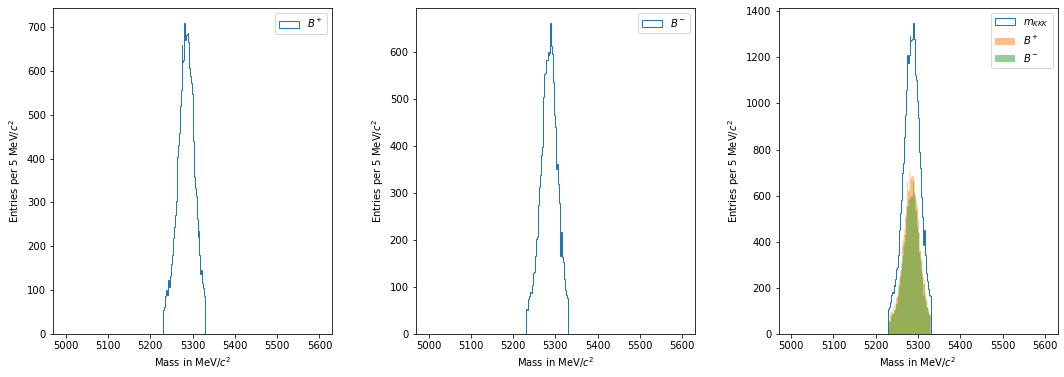

In [82]:
print('Plotting Histrogram for B+ and B-: ')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

values_m_KKK_p,bins_m_KKK_p,patches_m_KKK_p = ax[0].hist(m_KKK_p, bins = 300, range = [5000, 5600],histtype='step',label='$B^+$')
nBp = values_m_KKK_p.max()
print('Number of B^+ decay: ',nBp)

values_m_KKK_m,bins_m_KKK_m,patches_m_KKK_m = ax[1].hist(m_KKK_m, bins = 300, range = [5000, 5600],histtype='step',label='$B^-$')
nBm = values_m_KKK_m.max()
print('Number of B^- decay: ',nBm)

values_mKKK,bins_mKKK,patches_mKKK = ax[2].hist(m_KKK, bins = 300, range = [5000, 5600],histtype='step',label='$m_{KKK}$')
ax[2].hist(m_KKK_p, bins = 300, range = [5000, 5600],histtype='stepfilled',alpha=0.5,label='$B^+$')
ax[2].hist(m_KKK_m, bins = 300, range = [5000, 5600],histtype='stepfilled',alpha=0.5,label='$B^-$')

ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries per 5 MeV/$c^2$')
ax[0].legend()
#plt.savefig('mKKK.pdf')
ax[1].set_xlabel('Mass in MeV/$c^2$')
ax[1].set_ylabel('Entries per 5 MeV/$c^2$')
ax[1].legend()
ax[2].set_xlabel('Mass in MeV/$c^2$')
ax[2].set_ylabel('Entries per 5 MeV/$c^2$')
ax[2].legend()

#Global CP Asymmetry
gAsy = (nBm-nBp)/(nBm+nBp)
gAsyErr = np.sqrt( (1-(gAsy**2)) / (nBm+nBp) )
print('Global CP Asymmetry: ', gAsy, '+/-', gAsyErr)

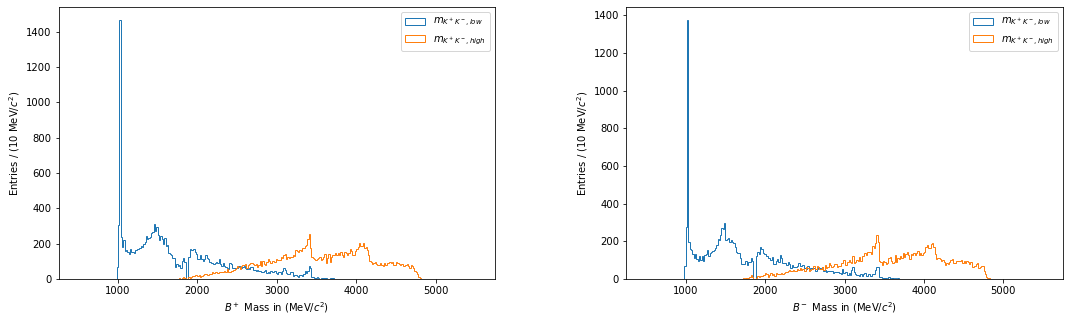

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

values_mKKlow_p,bins_mKKlow_p,patches_mKKlow_p = ax[0].hist(np.sqrt(mKKlow_p), bins = 300, range = [500,5500],histtype='step',label='$m_{K^+K^-,low}$')
values_mKKhigh_p,bins_mKKhigh_p,patches_mKKhigh_p = ax[0].hist(np.sqrt(mKKhigh_p), bins = 300, range = [500,5500],histtype='step',label='$m_{K^+K^-,high}$')
ax[0].set_xlabel(r'$B^+$ Mass in (MeV/$c^2$)')
ax[0].set_ylabel(r'Entries / (10 MeV/$c^2$)')
ax[0].legend()

values_mKKlow_m,bins_mKKlow_m,patches_mKKlow_m = ax[1].hist(np.sqrt(mKKlow_m), bins = 300, range = [500,5500],histtype='step',label='$m_{K^+K^-,low}$')
values_mKKhigh_m,bins_mKKhigh_m,patches_mKKhigh_m = ax[1].hist(np.sqrt(mKKhigh_m), bins = 300, range = [500,5500],histtype='step',label='$m_{K^+K^-,high}$')
ax[1].set_xlabel(r'$B^-$ Mass in (MeV/$c^2$)')
ax[1].set_ylabel(r'Entries / (10 MeV/$c^2$)')
ax[1].legend()
plt.savefig('figures/twobody_Bp_Bm.pdf')

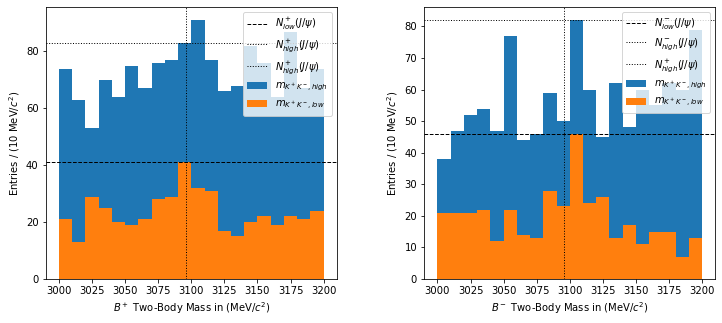

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

values_mKKhigh_p_zoom,bins_mKKhigh_p_zoom,patches_mKKhigh_p_zoom = ax[0].hist(np.sqrt(mKKhigh_p), bins = 20, range = [3000,3200],histtype='stepfilled',label='$m_{K^+K^-,high}$')
values_mKKlow_p_zoom,bins_mKKlow_p_zoom,patches_mKKlow_p_zoom = ax[0].hist(np.sqrt(mKKlow_p), bins = 20, range = [3000,3200],histtype='stepfilled',label='$m_{K^+K^-,low}$')
ax[0].axhline(41, color='k', linestyle='dashed', linewidth=1, label='$N^+_{low}(J/\psi)$')
ax[0].axhline(83, color='k', linestyle='dotted', linewidth=1, label='$N^+_{high}(J/\psi)$')
ax[0].axvline(3096, color='k', linestyle='dotted', linewidth=1, label='$N^+_{high}(J/\psi)$')
ax[0].set_xlabel(r'$B^+$ Two-Body Mass in (MeV/$c^2$)')
ax[0].set_ylabel(r'Entries / (10 MeV/$c^2$)')
ax[0].legend()

values_mKKhigh_m_zoom,bins_mKKhigh_m_zoom,patches_mKKhigh_m_zoom = ax[1].hist(np.sqrt(mKKhigh_m), bins = 20, range = [3000,3200],histtype='stepfilled',label='$m_{K^+K^-,high}$')
values_mKKlow_m_zoom,bins_mKKlow_m_zoom,patches_mKKlow_m_zoom = ax[1].hist(np.sqrt(mKKlow_m), bins = 20, range = [3000,3200],histtype='stepfilled',label='$m_{K^+K^-,low}$')
ax[1].axhline(46, color='k', linestyle='dashed', linewidth=1, label='$N^-_{low}(J/\psi)$')
ax[1].axhline(82, color='k', linestyle='dotted', linewidth=1, label='$N^-_{high}(J/\psi)$')
ax[1].axvline(3096, color='k', linestyle='dotted', linewidth=1, label='$N^+_{high}(J/\psi)$')
ax[1].set_xlabel(r'$B^-$ Two-Body Mass in (MeV/$c^2$)')
ax[1].set_ylabel(r'Entries / (10 MeV/$c^2$)')
ax[1].legend()
plt.savefig('figures/twobody_Bp_Bm_zoomed.pdf')

Plot Folded Dalitz


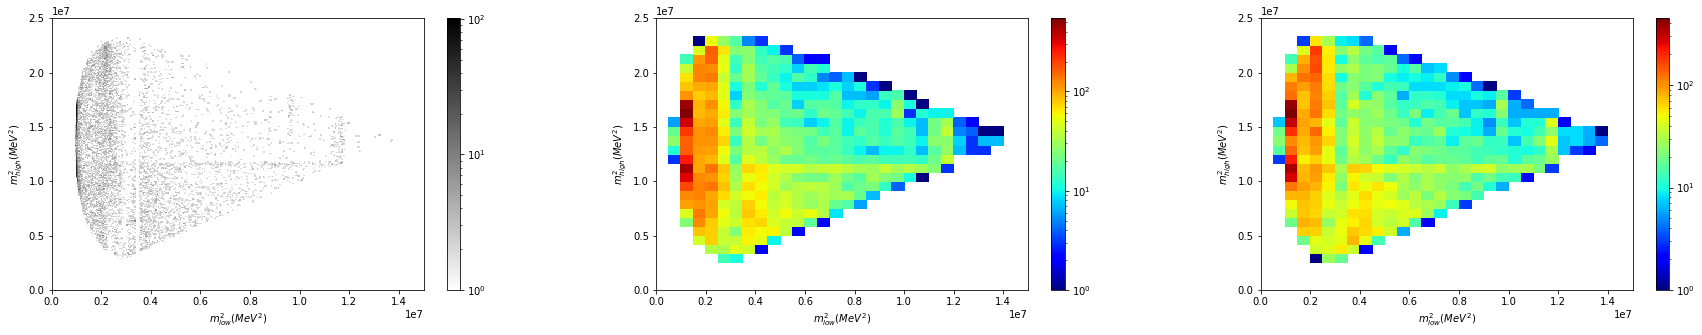

In [86]:
print('Plot Folded Dalitz')

#figsize=(60,10)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# Dalitz Plot KKK
h2d = ax[0].hist2d(mKKlow, mKKhigh, bins = [300,300], range = [[0,1.5e7],[0,2.5e7]], norm=colors.LogNorm(), cmap='binary')
ax[0].set_xlabel('$m_{low}^2 (MeV^2)$')
ax[0].set_ylabel('$m_{high}^2 (MeV^2)$')
#ax[0].set_title('Dalitz Folded')

h2dBp = ax[1].hist2d(mKKlow_p, mKKhigh_p, bins = [30,30], range = [[0,1.5e7],[0,2.5e7]], norm=colors.LogNorm(), cmap='jet')
ax[1].set_xlabel('$m_{low}^2 (MeV^2)$')
ax[1].set_ylabel('$m_{high}^2 (MeV^2)$')
#ax[1].set_title('Dalitz Folded B+')

h2dBm = ax[2].hist2d(mKKlow_m, mKKhigh_m, bins = [30,30], range = [[0,1.5e7],[0,2.5e7]], norm=colors.LogNorm(), cmap='jet')
ax[2].set_xlabel('$m_{low}^2 (MeV^2)$')
ax[2].set_ylabel('$m_{high}^2 (MeV^2)$')
#ax[2].set_title('Dalitz Folded B-')

fig.colorbar(h2d[3],ax=ax[0])
fig.colorbar(h2dBp[3],ax=ax[1])
fig.colorbar(h2dBm[3],ax=ax[2])

plt.savefig('figures/dalitz_folded.pdf')

## Local Asymmetry

Plot asymmetry Dalitz


<ipython-input-87-bbdcdd87df51>:18: RuntimeWarning: invalid value encountered in true_divide
  wAs = np.subtract(wBm,wBp)/np.add(wBm,wBp)
<ipython-input-87-bbdcdd87df51>:36: RuntimeWarning: divide by zero encountered in true_divide
  wAsig= wAs/wAerr


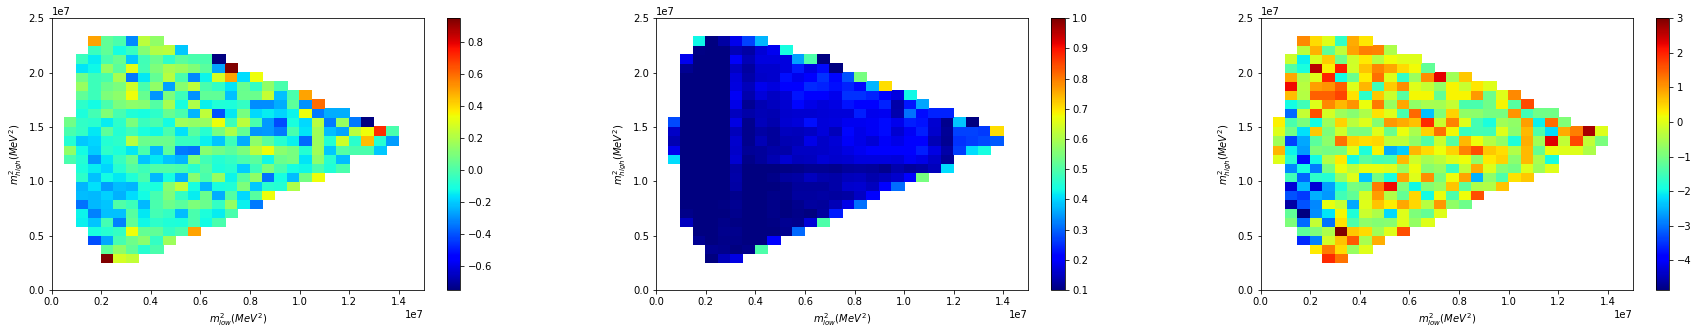

In [87]:
print('Plot asymmetry Dalitz')

#figsize=(60,10)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

xcentres_As = []
ycentres_As = []
for a,b in zip(h2dBp[1][0:-1],h2dBp[1][1:]):
    for c,d in zip(h2dBp[2][0:-1],h2dBp[2][1:]):
        xcentres_As.append( (a+b)/2 )
        ycentres_As.append( (c+d)/2 )

# extract the weights of h2dBp and h2dBm
wBp = (np.array(h2dBp[0])).flatten()
wBm = (np.array(h2dBm[0])).flatten()
# caluculate asymmetry
wAs = np.subtract(wBm,wBp)/np.add(wBm,wBp)

h2dAs = ax[0].hist2d(xcentres_As,ycentres_As, weights=wAs, bins = [h2dBp[1],h2dBp[2]], cmap='jet', vmin=-0.75, vmax=0.95)
ax[0].set_xlabel('$m_{low}^2 (MeV^2)$')
ax[0].set_ylabel('$m_{high}^2 (MeV^2)$')
#ax[0].set_title('Asymmetry Dalitz')
fig.colorbar(h2dAs[3],ax=ax[0])

#Error
wAerr = np.sqrt( (1-(wAs**2)) / (wBm+wBp) )
h2dAerr = ax[1].hist2d(xcentres_As,ycentres_As, weights=wAerr, bins = [h2dBp[1],h2dBp[2]], cmap='jet', vmin=0.1, vmax=1)
ax[1].set_xlabel('$m_{low}^2 (MeV^2)$')
ax[1].set_ylabel('$m_{high}^2 (MeV^2)$')
#ax[1].set_title('Asymmetry Error Dalitz')
fig.colorbar(h2dAerr[3],ax=ax[1])

#significance
#wAsig= np.sqrt(np.abs((wAs-1)/(wAs)))
wAsig= wAs/wAerr
h2dAsig = ax[2].hist2d(xcentres_As,ycentres_As, weights=wAsig, bins = [h2dBp[1],h2dBp[2]], cmap='jet')
ax[2].set_xlabel('$m_{low}^2 (MeV^2)$')
ax[2].set_ylabel('$m_{high}^2 (MeV^2)$')
#ax[2].set_title('Asymmetry Significance Dalitz')
fig.colorbar(h2dAsig[3],ax=ax[2])

plt.savefig('figures/asymmetry_dalitz.pdf')